# Stokes Cavity with an Ostwald fluid

In this notebook the Stokes cavity example is re-worked to incorporate a time independent non-Newtonian fluid model.

For the Stokes cavity equation with a Newtonian fluid we used the following governing equations:

$$\begin{equation}
\nabla\cdot(\mu\nabla\mathbf{u})=\nabla p\tag{1}\label{eq:StokesCav}
\end{equation}$$

And the continuity equation for incompressible fluid 

$$\begin{equation}\tag{2}\label{eq:Conteq}
\nabla\cdot\mathbf{u}=0
\end{equation}$$

where $\mathbf{u}$ is the fluid velocity field, $\mu$ is the dynamic viscosity and $p$ is the pressure field.

In this example we will adapt the solution used to incorporate a time-independent non-Newtonian fluid. Thus, the governing equation associated with momentum diffusion will have to be re-written as follows:

$$\begin{equation}\tag{3}\label{eq:StokesCav-PL}
\nabla\cdot\tau=\nabla p
\end{equation}$$

where $\tau$ is

$$\begin{equation}\tag{4}\label{eq:Stress-Tensor}
\tau=\mu(\dot\gamma)\dot\gamma
\end{equation}$$

For the apparent viscosity $\mu(\dot\gamma)$ we will incorporate an Ostwald fluid model and therefore it is expressed as:

$$\begin{equation}\tag{5}\label{eq:Stress-PL}
\mu(\dot\gamma)=C|\dot\gamma|^{m-1}
\end{equation}$$

Thus resulting in the final model below

$$\begin{equation}\tag{6}\label{eq:StokesCav-PL-1}
\nabla\cdot(C\dot|\dot\gamma|^{m-1}\dot\gamma)=\nabla p
\end{equation}$$

where $C$ and $m$ are two material constants. $C$ is typically related to the diffusion of momentum and $m$ is associated with the fluid behavior. In this form we assume a generalized Newtonian fluid model. For a 2-D flow, $\dot\gamma$ can be written as:

$$\begin{equation}\tag{7}\label{eq:gamma-2D}
\dot\gamma=\left[ \begin{array}{c c}
2\frac{\partial u}{\partial x} & \left(\frac{\partial u}{\partial y}+\frac{\partial v}{\partial x} \right)\\
\left(\frac{\partial u}{\partial y}+\frac{\partial v}{\partial x} \right) & 2\frac{\partial v}{\partial y}
\end{array}\right]
\end{equation}$$

Or in a compact form

$$
\dot\gamma=\frac{1}{2}(\nabla \mathbf{u}+\nabla \mathbf{u}^T)
$$

We can then re-write $\eqref{eq:StokesCav-PL-1}$ as

$$
\begin{equation}\tag{8}\label{eq:StokesCav-PL-2}
\nabla\cdot\left(\frac{C}{2}\dot|\dot\gamma|^{m-1}\nabla \mathbf{u}\right)+\nabla\cdot\left(\frac{C}{2}\dot|\dot\gamma|^{m-1}\nabla \mathbf{u}^T\right)=\nabla p
\end{equation}
$$

We shall work on Eq. $\eqref{eq:StokesCav-PL-2}$ in order to obtain a better visualization of the equations to take place in the algorithm. In this case we re-write it using index notation, resulting in

$$
\begin{equation}\tag{9}\label{eq:StokesCav-PL-3}
\frac{\partial }{\partial x_i}\left(\frac{C}{2}|\dot\gamma|^{m-1}\frac{\partial u_k}{\partial x_i}\right)\mathbf{e}_k+
\frac{\partial }{\partial x_i}\left(\frac{C}{2}|\dot\gamma|^{m-1}\frac{\partial u_i}{\partial x_k}\right)\mathbf{e}_k=
\frac{\partial p}{\partial x_k}\mathbf{e}_k
\end{equation}
$$

Note that, in this case, we have 2 equations for the 2 directions and 2 velocity variables which are in both equations. Therefore we will use a solution where we first solve one equation for one velocity direction and then use the result to solve for the other direction.

We start importing the required libraries and setting some governing parameters of the problem. It is very similar to the Stokes cavity Newtonian example, but here we have also included $m$ value and adapt the relaxation values to ones that worked fine for a range of $0.5\leqslant m\leqslant 1.5$. Note that with different values of $m$, we represent $C$ as the viscosity, the number of sweeps required to converge may increase significantly. Consequently, we have incorporated a factor $\epsilon$ to let the loop converge to a maximum residual, instead of the number of loops.

Here we consider a 2D cavity with unit dimensions, no-slip condition at the walls, with a unit speed at the upper boundary. The mesh will consist of $50 \times 50$ grid.

In [1]:
import numpy as np

from fipy import (
    Grid2D,
    CellVariable,
    FaceVariable,
    DiffusionTerm,
    Viewer,
    numerix
)

In [2]:
L = 1.0 # Cavity dimensions
N = 50 # Number of divisions
dL = L / N # Cell sizes
viscosity = 1. # Consistency viscosity value. The value "C" from Ostwald fluid model.
m = 1.5 # First value of the behavior constant will set the case as Newtonian
eps = 0.025 # criteria to stop
U = 1.0 # upper boundary fluid velocity
#   0.4 for pressure and 0.02 for velocity worked fine for 0.5<=m<=1.5
#   worked for m=0.25
pressureRelaxation = 0.4
velocityRelaxation = 0.02 
Re = U ** (2 - m) * L ** m / viscosity # Added non-Newtonian Reynolds number calculation for reference
# the number of sweeps when explicit called is 300, when running as a test is 5
sweeps = 15000

We then build the mesh using a 2D grid.

In [3]:
mesh = Grid2D(nx=N, ny=N, dx=dL, dy=dL)

Then, we create the variables which keep the solution value and initialize it with null values. In this case we need variables for pressure, pressure correction, and two directions of the velocity field.

In [4]:
pressure = CellVariable(mesh=mesh, name='pressure')
pressureCorrection = CellVariable(mesh=mesh)
xVelocity = CellVariable(mesh=mesh, name='X velocity')
yVelocity = CellVariable(mesh=mesh, name='Y velocity')

For coupling purposes the velocity is also declared as a face variable. It will be used to apply the [SIMPLE](https://en.wikipedia.org/wiki/SIMPLE_algorithm) calculation for pressure correction.

In [5]:
velocity = FaceVariable(mesh=mesh, rank=1)

Compute the shear strain, which is used in the velocity equation.

In [6]:
velocity_variable = CellVariable(mesh=mesh, name='vel_var',rank=1)

# need this to get through the first step without error
velocity_variable[:] = 1e-6 * np.random.random(velocity_variable.shape)

In [7]:
def trans2x2(var):
    # Transpose for  2 x 2 variable
    return [[1, 0], [0, 1]] * var + [[0, 1], [0, 0]] * var[1, 0] + [[0, 0], [1, 0]] * var[0, 1]

def mag2x2(var):
    # Magnitude for 2 x 2 variable
    return numerix.sqrt((var**2).sum(0).sum(0))

In [8]:
shear_strain = 0.5 * (velocity_variable.grad + trans2x2(velocity_variable.grad))

In [9]:
def xterm(mat):
    return viscosity * np.array(mat) * mag2x2(shear_strain) ** (m-1)

xTerm1 = xterm([[1, 0], [0, 1 / 2]])
xTerm2 = xterm([[0, 1 / 2], [0, 0]])
yTerm1 = xterm([[0, 0], [0, 1 / 2]])
yTerm2 = xterm([[1 / 2, 0], [0, 1]])

In [10]:
xVelocityEq = DiffusionTerm(xTerm1,var=xVelocity)+DiffusionTerm(xTerm2,var=yVelocity)-pressure.grad.dot([1., 0.])
yVelocityEq = DiffusionTerm(yTerm1,var=xVelocity)+DiffusionTerm(yTerm2,var=yVelocity)-pressure.grad.dot([0., 1.])

We need the pressure correction equation.

In [11]:
ap = CellVariable(mesh=mesh, value=1.)
coeff = 1. / ap.arithmeticFaceValue * mesh._faceAreas * mesh._cellDistances
pressureCorrectionEq = DiffusionTerm(coeff=coeff) - velocity.divergence

This method also incorporates the Rhie-Chow interpolation correction to soften the numerical oscillations. For the SIMPLE method we linearize the equation and use the linear coefficients, and we can use the same approach, even though we now have a non-Newtonian fluid.

In [12]:
from fipy.variables.faceGradVariable import _FaceGradVariable
volume = CellVariable(mesh=mesh, value=mesh.cellVolumes, name='Volume')
contrvolume = volume.arithmeticFaceValue

Set the boundary conditions to no slip and uniform velocity in the upper boundary.

In [13]:
xVelocity.constrain(0., mesh.facesRight | mesh.facesLeft | mesh.facesBottom)
xVelocity.constrain(U, mesh.facesTop)
yVelocity.constrain(0., mesh.exteriorFaces)
X, Y = mesh.faceCenters
pressureCorrection.constrain(0., mesh.facesLeft & (Y < dL))

Set up the viewers

In [14]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,10)

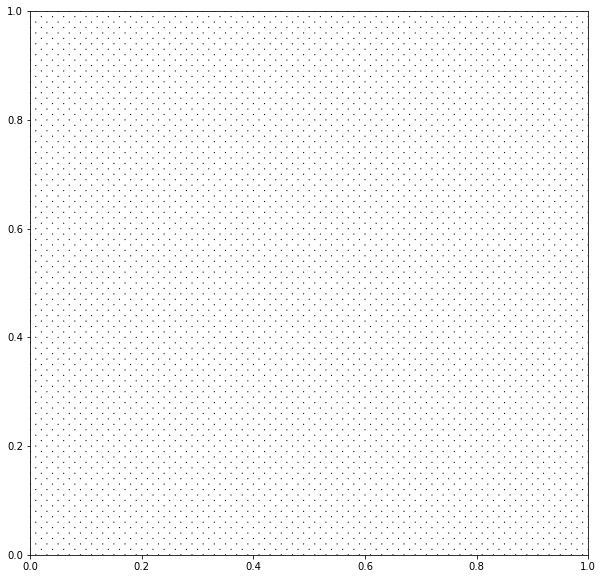

In [15]:
if __name__ == '__main__':
    viewer = Viewer(vars=(velocity),
               xmin=0., xmax=1., ymin=0., ymax=1., colorbar=True,scale=5)

Now solve the problem with sweep instead of solve.

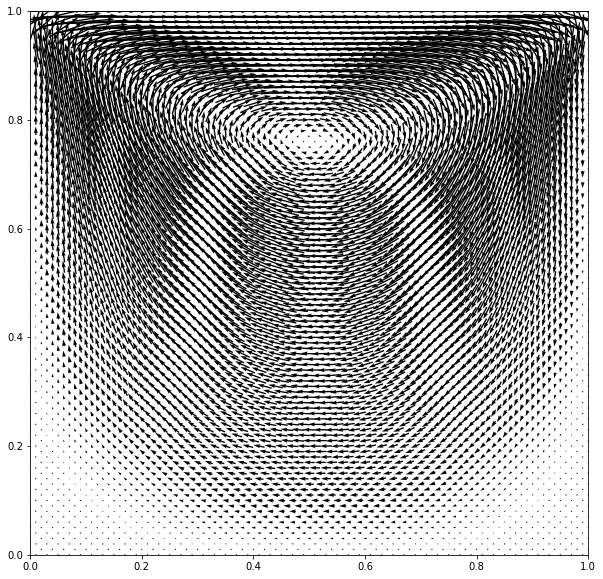

Residuals are less than: 0.025


<Figure size 720x720 with 0 Axes>

In [16]:
for sweep in range(sweeps):
# while min(xres,yres) > 0.01:
    
     ## solve the Stokes equations to get starred values
     xVelocityEq.cacheMatrix()
     
     # solving for x and y velocities
     
     xres = xVelocityEq.sweep(var=xVelocity,
                              underRelaxation=velocityRelaxation)
  
     xmat = xVelocityEq.matrix

     yres = yVelocityEq.sweep(var=yVelocity,
                              underRelaxation=velocityRelaxation)

     # solving again to adjust the x and y velocity values ########################
     xres = xVelocityEq.sweep(var=xVelocity,
                              underRelaxation=velocityRelaxation)
     xmat = xVelocityEq.matrix

     yres = yVelocityEq.sweep(var=yVelocity,
                              underRelaxation=velocityRelaxation)
     ############################################################################
     
    
     ## update the ap coefficient from the matrix diagonal
     ap[:] = -numerix.asarray(xmat.takeDiagonal())

     ## update the face velocities based on starred values with the
     ## Rhie-Chow correction.
     ## cell pressure gradient
     presgrad = pressure.grad
     ## face pressure gradient
     facepresgrad = _FaceGradVariable(pressure)

     velocity[0] = xVelocity.arithmeticFaceValue \
          + contrvolume / ap.arithmeticFaceValue \
          * (presgrad[0].arithmeticFaceValue-facepresgrad[0])
     velocity[1] = yVelocity.arithmeticFaceValue \
          + contrvolume / ap.arithmeticFaceValue \
          * (presgrad[1].arithmeticFaceValue-facepresgrad[1])
     velocity[..., mesh.exteriorFaces.value] = 0.
     velocity[0, mesh.facesTop.value] = U

     ## solve the pressure correction equation
     pressureCorrectionEq.cacheRHSvector()
     ## left bottom point must remain at pressure 0, so no correction
     pres = pressureCorrectionEq.sweep(var=pressureCorrection)
     rhs = pressureCorrectionEq.RHSvector

     ## update the pressure using the corrected value
     pressure.setValue(pressure + pressureRelaxation * pressureCorrection )
     ## update the velocity using the corrected pressure
     xVelocity.setValue(xVelocity - pressureCorrection.grad[0] \
                                  / ap * mesh.cellVolumes)
     yVelocity.setValue(yVelocity - pressureCorrection.grad[1] \
                                  / ap * mesh.cellVolumes)
     
     velocity_variable.setValue([xVelocity,yVelocity])

     if __name__ == '__main__':
         if sweep % 50 == 0:
             print('sweep:', sweep, ', x residual:', xres, \
                                    ', y residual',  yres, \
                                    ', p residual:', pres, \
                                    ', continuity:', max(abs(rhs)))
             plt.figure(num=1, figsize=(10,10))
     
             viewer.plot()

     # Criteria to stop
     if (max(xres, yres) < eps):
        print("Residuals are less than: {0}".format(eps))
        break        
     else:
        continue